In [269]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
from random import randint
from PIL import Image

In [270]:
df = pd.read_csv('Big_project/mnist_test.csv', header=None)
train_X = np.array(df.iloc[:9600, 1:]).astype(float)
test_X = np.array(df.iloc[9600:, 1:]).astype(float)
train_y = np.array(df.iloc[:9600, 0]).astype(float)
test_y = np.array(df.iloc[9600:, 0]).astype(float)

In [271]:
Layers = (784, 25, 25, 10)

In [272]:
#Takes in a list of numpy matrixes and returns a flattened version
#theta in the parameter is a tuple of matrixes
def flatten(theta):
    if len(theta) == 0:
        return np.array([])
    else:
        return np.concatenate((theta[0].flatten(), flatten(theta[1:])))

In [273]:
#Takes in a flattened row of parameters and reshapes them in aaccordance
#to the Layers global variable

#Returns a list of the unflattened row
def unflatten(theta):
    param = []
    start = 0
    end = 0
    for i in range(0, len(Layers) - 1):
        end += Layers[i+1] * (Layers[i] + 1)
        param.append(theta[start:end].reshape(Layers[i+1], Layers[i] + 1))
        start = end
    return param

In [274]:
def sigmoid(z):
    return 1 / (1 + pow(np.e, -z))

In [275]:
def ddx_sigmoid(z):
    return sigmoid(z) * (1 - sigmoid(z))

In [276]:
def normalize(X_norm):
    mean_std = []
    X_copy = X_norm.copy()
    for i in range(0, X_norm.shape[1]):
        mean = np.mean(X_norm[:, i])
        std = np.std(X_norm[:, i])
        if std != 0:
            X_copy[:, i] = (X_norm[:, i] - mean) / std
            mean_std.append((mean, std))
        else:
            X_copy[:, i] = 0
            mean_std.append((0, 1))
    return X_copy, mean_std

In [277]:
#Takes in the matrix of X values (m x n) and a vector of y values (m,) and 
# a flattened version of the parameters, a lambda_

# returns the flattened gradient of the function at the current theta, 
# and also returns the cost of the function at that given location

# a = [A1, A2, A3...AL]
# z = [Z1, Z2, Z3...Z(L-1)]
# d = [D2, D3...D(L-1)]

def grad_and_cost(X, y, theta, lambda_=0):
    J = 0
    grads = []
    
    m = y.size
    X = np.hstack((np.ones((m, 1)), X))
    thetas = unflatten(theta)
    for i in range(0, len(thetas)):
        grads.append(np.zeros(thetas[i].shape))
    for num in range(0, m):
        vy = np.zeros(Layers[-1])
        vy[int(y[num])] = 1
        a = [X[num, :]]
        z = []
        #This is going through the thetas and setting the a and z values
        #The size of z will be one less than the size of a
        #Reason is because the first layer does not have a z value
        for i in range(0, len(thetas)):
            z.append(np.matmul(thetas[i], a[i]))
            a_val = sigmoid(z[i])
            if i != len(thetas) - 1:
                a_val = np.hstack((1, a_val))
            a.append(a_val)
        
        #Setting the values for delta, the error in each layer
        #Like z, this one is one less element than a because
        #the first layer is not included as a delta value
        #(Because there is no 'error' for the predefined values)
        d = [None] * (len(Layers) - 1)
        for i in range(len(d) - 1, -1, -1):
            if i == len(d) - 1:
                d[i] = (a[i + 1] - vy)
            else:
                d[i] = np.matmul(thetas[i+1].T, d[i+1])[1:] * ddx_sigmoid(z[i])
        
        #Finally caluclating the gradients
        for i in range(0, len(Layers) - 1):
            #reshape (1, -1) broadcasts shape of vector (x,) to matrix (1, z)
            grads[i] += np.matmul(d[i].reshape(-1, 1), (a[i].reshape(1, -1)))
        #Finding the cost
        J += sum(vy * np.log(a[-1]) + (1 - vy) * np.log(1 - a[-1]))
    J /= -m
    
    #Adding on the regularization to both the cost and the gradient
    reg = 0
    for i in range(0, len(thetas)):
        reg += np.sum(thetas[i][:, 1:] ** 2)
        grads[i][:, 1:] += lambda_ * thetas[i][:, 1:]
    reg *= lambda_ / (2 * m)
    J += reg
    fgrads = flatten(grads)
    fgrads /= m
    return fgrads, J

In [278]:
##THIS IS ONLY TO VERIFY GRADIENT IS CORRECT

def get_cost(X, y, theta, lambda_=0):
    tot = 0
    m = y.size
    X = np.hstack((np.ones((m, 1)), X))
    thetas = unflatten(theta)
    for num in range(0, m):
        vy = np.zeros(Layers[-1])
        vy[int(y[num])] = 1
        a = [X[num, :]]
        z = []
        for i in range(0, len(thetas)):
            z.append(np.matmul(thetas[i], a[i]))
            a_val = sigmoid(z[i])
            if i != len(thetas) - 1:
                a_val = np.hstack((1, a_val))
            a.append(a_val)
        tot += sum(vy * np.log(a[-1]) + (1 - vy) * np.log(1 - a[-1]))
    return tot / -m

In [279]:
def front_prop(x, theta):
    m = Layers[-1]
    x = np.hstack((1, x))
    thetas = unflatten(theta)
    a = [x]
    z = []
    for i in range(0, len(thetas)):
        z.append(np.matmul(thetas[i], a[i]))
        a_val = sigmoid(z[i])
        if i != len(thetas) - 1:
            a_val = np.hstack((1, a_val))
        a.append(a_val)
    return a[-1]

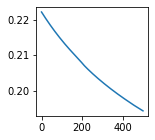

In [280]:
xx = np.arange(0, 500)
Js = []
# the = np.random.uniform(-0.12, 0.12, (20535,))
train_X, factors = normalize(train_X)
for i in range(0, 500):
    gra, J = grad_and_cost(train_X, train_y, the, 1.5)
    the -= 1 * gra
    Js.append(J)
plt.plot(xx, Js)

In [295]:
tempx = test_X.copy()
tempy = test_y.copy()
for (i, fact) in zip(range(0, 784), factors):
    if fact[1] != 0:
        tempx[:, i] = (tempx[:, i] - fact[0]) / fact[1]
    else:
        tempx[:, i] = 0
good = 0
for i in range(0, tempx.shape[0]):
    fr = front_prop(tempx[i, :], the)
    if np.argmax(fr) == tempy[i] and np.max(fr) >= 0.5:
        good += 1
print(good / tempy.size)

0.8225


In [282]:
def predict_image(file):
    img = np.array(Image.open(file).convert('L')).astype(float)
    img = 255 - img
    plt.imshow(img, cmap='Greys')
    plt.clim()
    plt.axis('off')
    plt.rcParams['figure.figsize']=2, 2
    
    #flattens and normalizes the img to same parameters as the traning set
    img = img.flatten()
    for i in range(0, len(factors)):
        if factors[i][1] != 0:
            img[i] = (img[i] - factors[i][0]) / factors[i][1]
        else:
            img[i] = 0
    pred = front_prop(img, the)
    for i in range(0, len(pred)):
        print(str(i) + " : " + str(round(pred[i]*100, 3)) + "%")

0 : 0.003%
1 : 0.274%
2 : 99.199%
3 : 0.11%
4 : 0.0%
5 : 0.0%
6 : 0.051%
7 : 0.241%
8 : 0.092%
9 : 0.0%


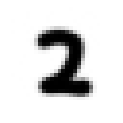

In [323]:
predict_image('Big_project/Numbers/test53.jpg')